In [3]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
!pip install image
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/d1/21/bef2816809fac16754e07ed935469fc65f42ced1a94766de7c804179311d/Pillow-5.3.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
distributed 1.21.8 requires msgpack, which is not installed.
keras 2.2.4 has requirement keras_applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
keras 2.2.4 has requirement keras_preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
distributed 1.21.8 requires msgpack, which is not installed.
keras 2.2.4 has requirement keras_a

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is not available.  Training on CPU ...
cpu


In [5]:
data_dir = '/b_cancer_data2'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()

In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'b_cancer_data2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

class_names = image_datasets['train'].classes

print("IMAGE_DATASETS:",image_datasets)
print("DATALOADERS:",dataloaders)

IMAGE_DATASETS: {'train': Dataset ImageFolder
    Number of datapoints: 159
    Root location: b_cancer_data2/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-30, 30), resample=False, expand=False)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'valid': Dataset ImageFolder
    Number of datapoints: 35
    Root location: b_cancer_data2/valid
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
DATALOADERS: {'train': <torch.utils.data.dataloader.DataLoader object at 0x112d38710>, 'valid': <torch.uti

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<function matplotlib.pyplot.show(*args, **kw)>

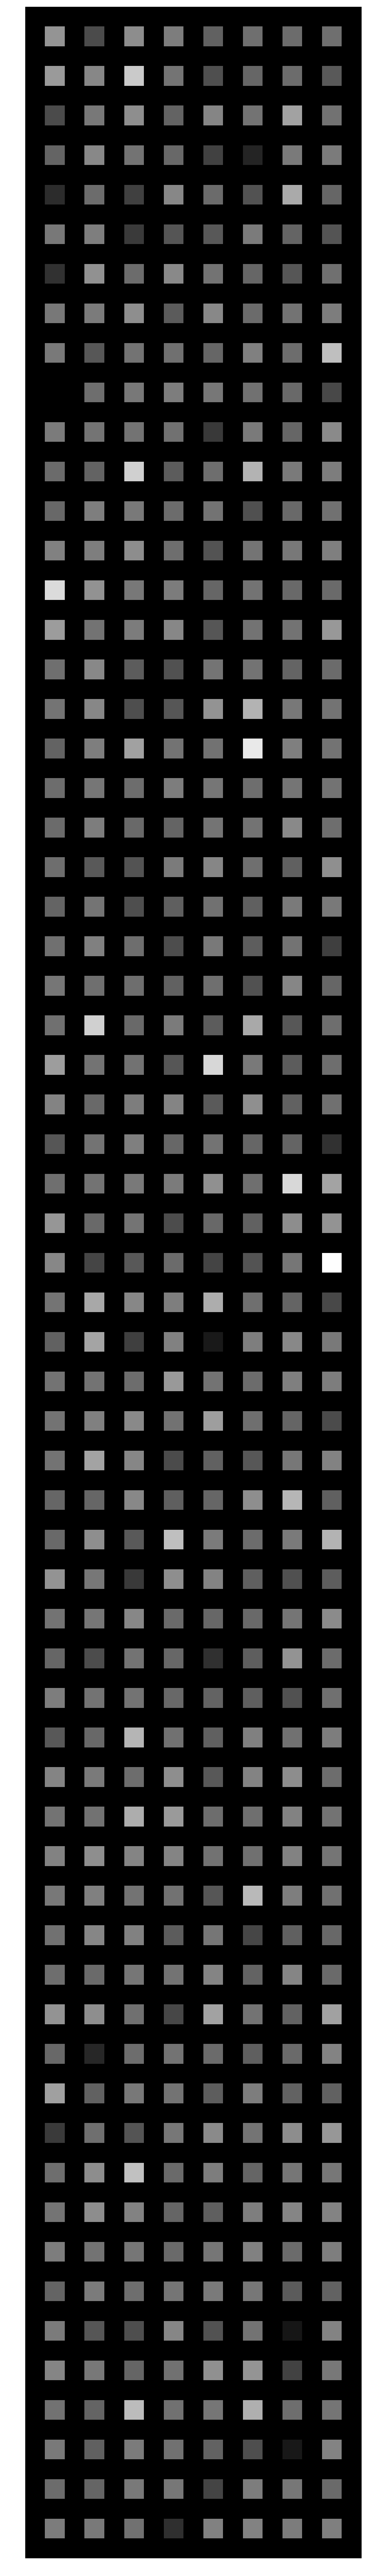

In [11]:
model = torchvision.models.resnet152(pretrained=True)
Model = torchvision.models.alexnet(pretrained=True)
print(model)
for param in model.parameters():
    param.requires_grad = False
    

from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt


def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
  
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
   
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )


x=0

print(model.layer2[0].conv3.weight.size())
kernels = model.layer2[0].conv3.weight.detach()
vistensor(kernels, ch=0, allkernels=False)
savetensor(kernels,'check.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

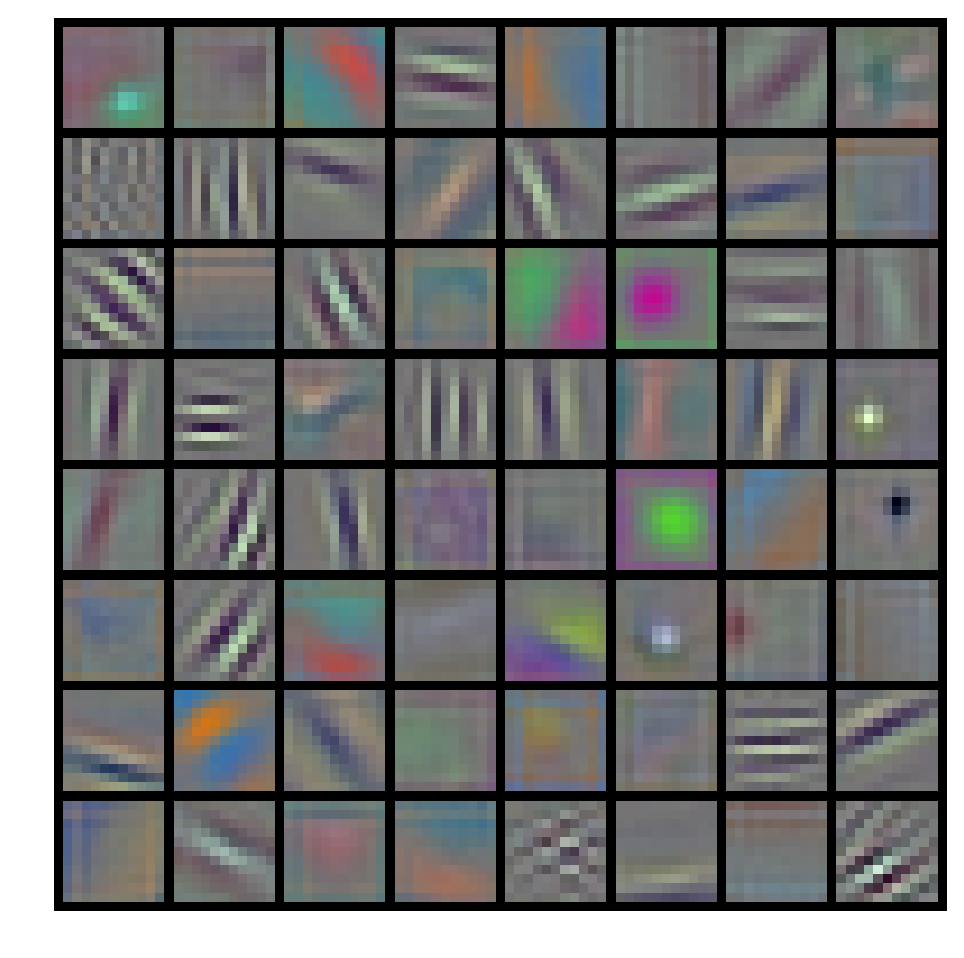

In [13]:
print(Model)
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt


def vistensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
        
    rows = np.min( (tensor.shape[0]//nrow + 1, 64 )  )    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

def savetensor(tensor, filename, ch=0, allkernels=False, nrow=8, padding=2):
    
    n,c,w,h = tensor.shape
    if allkernels: tensor = tensor.view(n*c,-1,w,h )
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)    
    utils.save_image(tensor, filename, nrow=nrow )


x = 0
print(Model.features[x])

kernel = Model.features[x].weight.data.clone()
vistensor(kernel, ch=0, allkernels=False)
savetensor(kernel,'check.png', allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()

In [14]:
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

model.fc = classifier

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()   
                
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [12]:
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.fc.parameters(), lr = .0006, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------
train Loss: 0.3126 Acc: 0.8772
valid Loss: 0.3267 Acc: 0.8587

Epoch 2/10
----------
train Loss: 0.3089 Acc: 0.8809
valid Loss: 0.3109 Acc: 0.8753

Epoch 3/10
----------
train Loss: 0.2941 Acc: 0.8861
valid Loss: 0.3213 Acc: 0.8625

Epoch 4/10
----------
train Loss: 0.2899 Acc: 0.8849
valid Loss: 0.3074 Acc: 0.8740

Epoch 5/10
----------
train Loss: 0.2932 Acc: 0.8840
valid Loss: 0.3180 Acc: 0.8740

Epoch 6/10
----------
train Loss: 0.2641 Acc: 0.8960
valid Loss: 0.3076 Acc: 0.8753

Epoch 7/10
----------
train Loss: 0.2666 Acc: 0.8947
valid Loss: 0.3045 Acc: 0.8740

Epoch 8/10
----------
train Loss: 0.2712 Acc: 0.8936
valid Loss: 0.3043 Acc: 0.8740

Epoch 9/10
----------
train Loss: 0.2661 Acc: 0.8985
valid Loss: 0.3061 Acc: 0.8766

Epoch 10/10
----------
train Loss: 0.2721 Acc: 0.8954
valid Loss: 0.3056 Acc: 0.8734

Training complete in 26m 23s
Best valid accuracy: 0.876598


In [16]:
def test_Model(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))



In [18]:
test_model(model, dataloaders, device)

Testing Accuracy: 0.8312
Testing Accuracy: 0.8616


In [23]:
num_epochs=10
model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 2,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
torch.save(checkpoint, '8960_checkpoint.pth')

In [24]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    input_size = 2048
    output_size = 2
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']

loaded_model, class_to_idx = load_checkpoint('8960_checkpoint.pth')
idx_to_class = { v : k for k,v in class_to_idx.items()}

In [25]:
def process_image(image):
    
    #pytorch
    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage

In [26]:
def imshow(image, ax=None, title=None):

    if ax is None:
        fig, ax = plt.subplots()
    
   
    image = image.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [27]:
def predict(image_path, model, topk=2):
        
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

In [20]:
print (predict('b_cancer_data2/valid/MALIGNANT/SOB_M_DC-14-2985-200-007.png', loaded_model))

(array([0.8490987 , 0.15090132], dtype=float32), ['MALIGNANT', 'BENIGN'])


In [28]:
def view_classify(img, probabilities, classes, mapper):
    
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    cancer_type = mapper[img_filename]
    
    ax1.set_title(cancer_type)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()

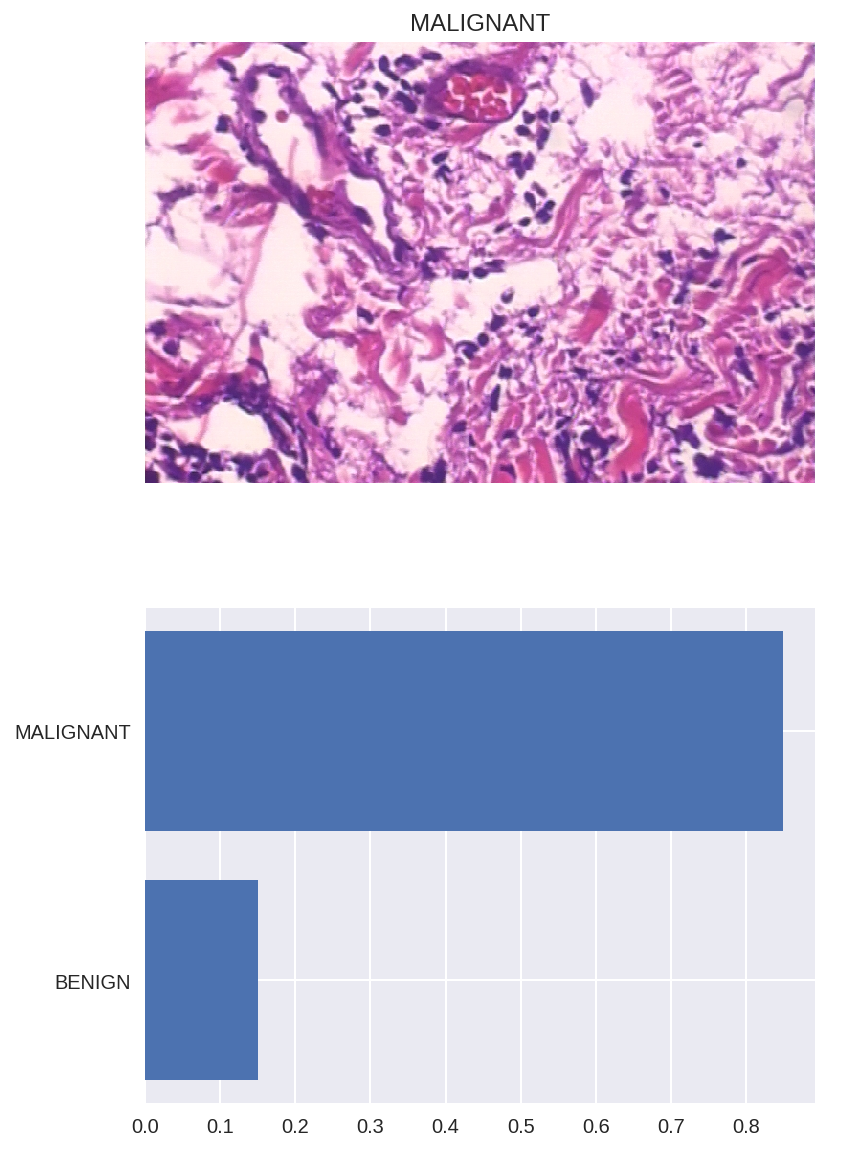

In [24]:
img = 'b_cancer_data2/valid/MALIGNANT/SOB_M_DC-14-2985-200-007.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

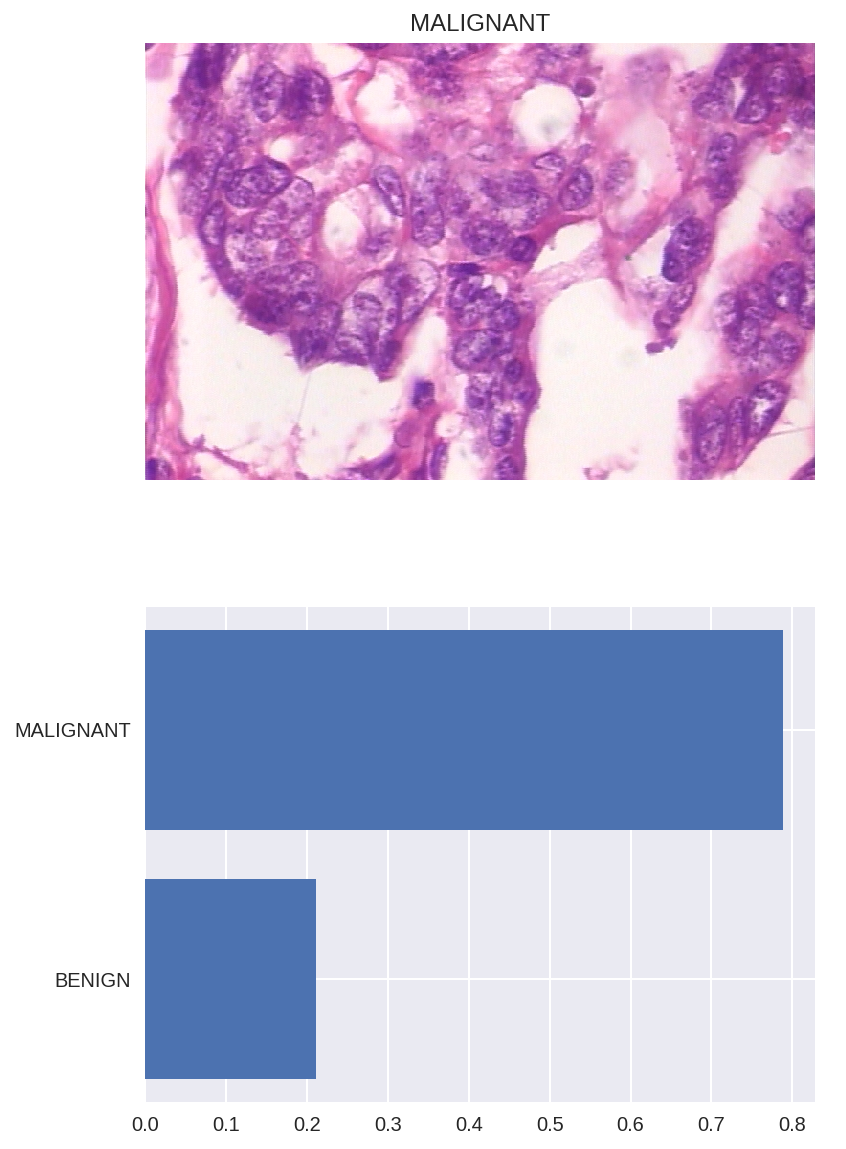

In [28]:
img = 'b_cancer_data2/valid/MALIGNANT/SOB_M_PC-14-12465-400-013.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

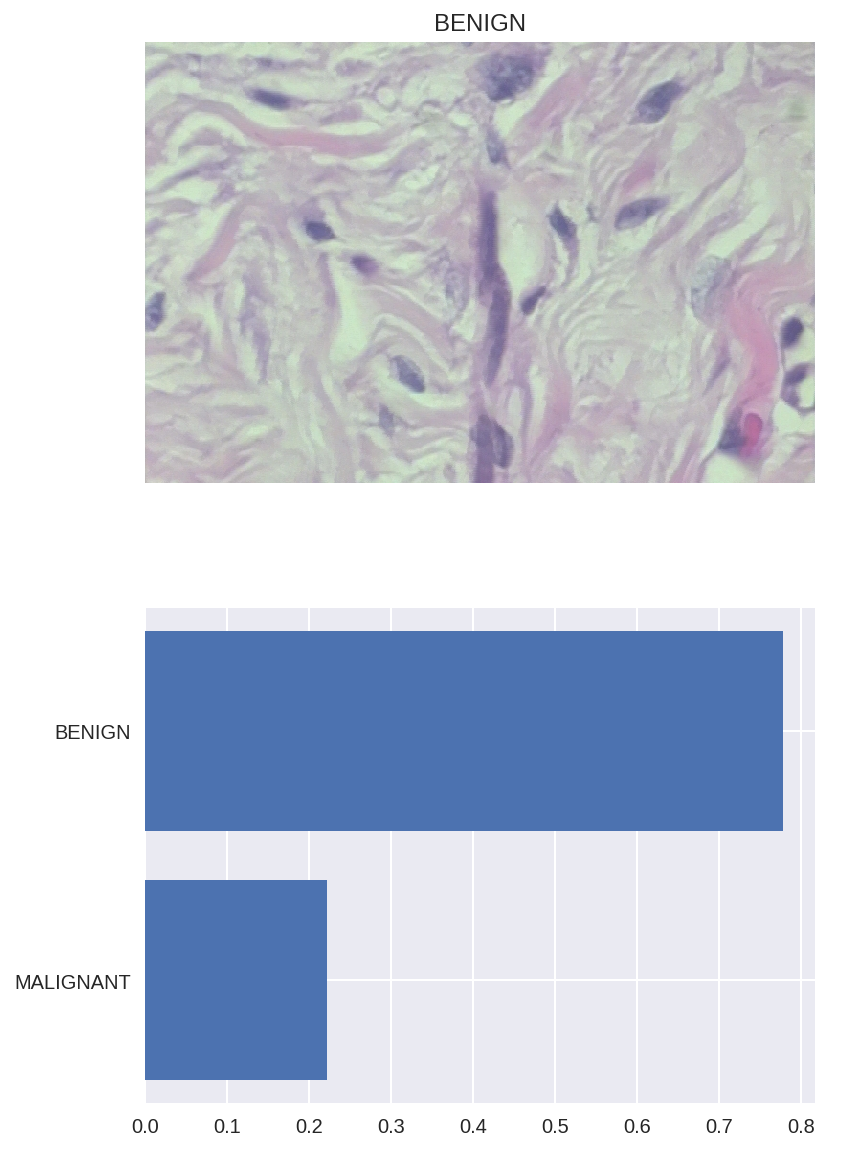

In [33]:
img = 'b_cancer_data2/valid/BENIGN/SOB_B_A-14-22549AB-400-005.png'
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)

In [ ]:
import os
import pandas as pd

BASE_DIR = 'b_cancer_data2/'
train_folder = BASE_DIR+'valid/MALIGNANT/'


files_in_train = sorted(os.listdir(train_folder))


images=[i for i in files_in_train]

df = pd.DataFrame()
df['images']=[train_folder+str(x) for x in images]
df['malignant']=0
df['benign']=0

for x in df['images']:
    
    p, c = predict(x, loaded_model)
    df['malignant']=p[0]
    df['benign']=p[1]
    #view_classify(x, p, c, cat_to_name)
    
df.to_csv('files_path.csv', header=None)

In [32]:
import csv
with open('files_path.csv','rt')as f:
  data = csv.reader(f)
  for row in data:
        print(row)

['S.no', 'PATH', 'BENIGN', 'MALIGNANT']
['0', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-001.png', '0.870870871', '0.129129129']
['1', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-002.png', '0.940940941', '0.059059059']
['2', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-003.png', '0.840840841', '0.159159159']
['3', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-004.png', '0.950950951', '0.049049049']
['4', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-005.png', '0.900900901', '0.099099099']
['5', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-006.png', '0.990990991', '0.009009009']
['6', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-007.png', '0.820820821', '0.179179179']
['7', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-008.png', '0.870870871', '0.129129129']
['8', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-009.png', '0.950950951', '0.049049049']
['9', 'b_cancer_data2/valid/MALIGNANT/SOB_B_A-14-22549CD-40-